# Correlation lengths - non_triv proj rep

Created 04/12/2025

Objectives:
* Found some weird results in [this notebook](correlation_lengths.ipynb) showing that the non trivial proj rep states had a lower correlation length! Replicate here in a clean envirionment to make sure.

# Package imports

In [4]:
import sys
sys.path.append('../')

In [5]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [7]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator,
    get_transfer_matrix_from_unitary,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

In [8]:
from functools import reduce

# Load data

In [9]:
DATA_DIR = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [10]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [11]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [12]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [13]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [14]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [15]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [16]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [17]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [18]:
fermionic_np_symmetries = [np_I, np_JW]

In [19]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [20]:
npc_JW = fermionic_npc_symmetries[1]

In [21]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [22]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [24]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [25]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [26]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [27]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Analysis

## Z-like operators

In [28]:
np_z_01 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
])

np_z_10 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

np_z_11 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [29]:
bosonic_np_phase_operators = [
    np_z_01,
    np_z_10,
    np_z_11
]

bosonic_npc_phase_operators = [
    to_npc_array(X)
    for X in bosonic_np_phase_operators
]

In [31]:
interpolation_values = sorted(list(energies_non_triv_proj_rep.keys()))

In [33]:
distances = list(range(1, 21))

In [35]:
def get_two_point_boson_op_expectation(psi, distance, op):
    ops = [op,] + ['Id',]*(2*distance-1) + [op]

    left_site = (200 - distance)//2

    if (left_site % 2) == 1:
        left_site += 1

    return psi.expectation_value_multi_sites(ops, left_site)

In [36]:
boosn_phase_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_phase_2_point_non_triv_proj_rep.append(list())
    for op in bosonic_npc_phase_operators:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_phase_2_point_non_triv_proj_rep[-1].append(out)

boosn_phase_2_point_non_triv_proj_rep = np.array(
    boosn_phase_2_point_non_triv_proj_rep
)

In [37]:
boosn_phase_2_point_non_triv_proj_rep.shape

(21, 3, 20)

In [38]:
bosonic_phase_operator_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_phase_operator_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in bosonic_npc_phase_operators:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_phase_operator_non_triv_proj_rep_exps[-1].append(out)

bosonic_phase_operator_non_triv_proj_rep_exps = np.array(bosonic_phase_operator_non_triv_proj_rep_exps)

In [39]:
boson_phase_operator_correlation_non_triv_proj_rep = (
    boosn_phase_2_point_non_triv_proj_rep
    - (np.array(bosonic_phase_operator_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

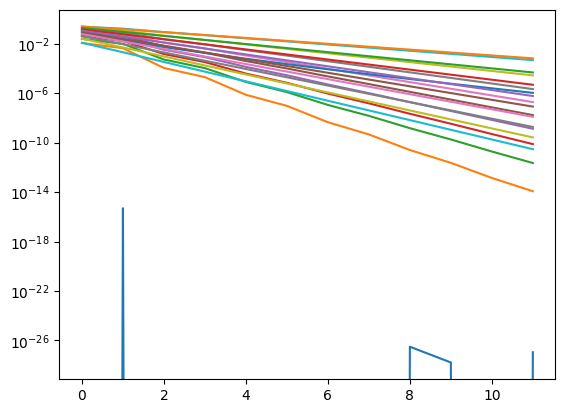

In [40]:
for X in boson_phase_operator_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

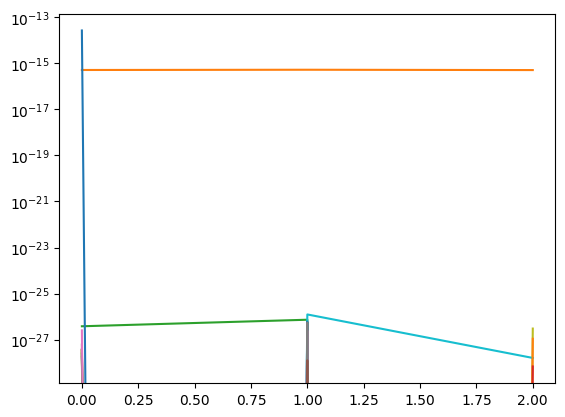

In [41]:
plt.plot(boson_phase_operator_correlation_non_triv_proj_rep[0,:12])
plt.plot(boson_phase_operator_correlation_non_triv_proj_rep[-1,:12])

plt.yscale('log')

In [45]:
X = boson_phase_operator_correlation_non_triv_proj_rep[:, 2, :]
num_sites = X.shape[-1]

boson_phase_op_correlation_lengths_non_triv_proj_rep = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
boson_phase_op_correlation_lengths_non_triv_proj_rep[0] = 0
boson_phase_op_correlation_lengths_non_triv_proj_rep[-1] = 0

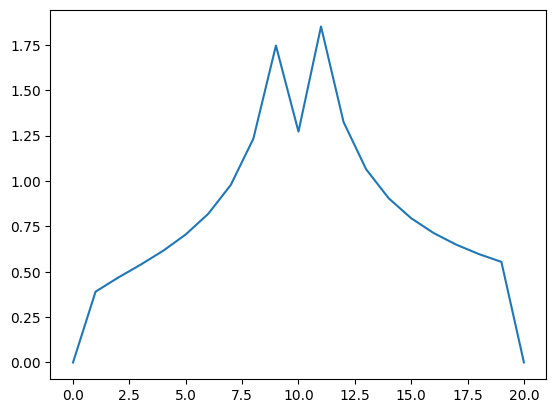

In [46]:
plt.plot(boson_phase_op_correlation_lengths_non_triv_proj_rep)

# Conclusions
It's the same!